In [1]:
import math
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2

(246, 340)


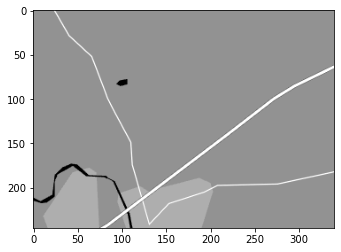

In [2]:
test=cv2.imread("legend.png")
#test=cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test=cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
plt.imshow(test, cmap="gray")
print(test.shape)

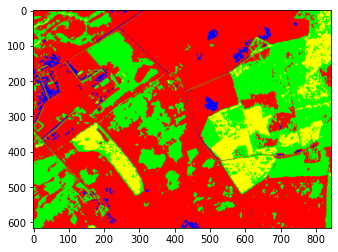

In [3]:
testcoloured=cv2.imread("coloured.png")
plt.imshow(testcoloured)

In [4]:
class Position:
    def __init__(self, yCoordinate, xCoordinate):
        self.Visited=False
        self.xCoordinate=xCoordinate
        self.yCoordinate=yCoordinate
        self.fromOrigin=np.inf
        self.Danger=5
        self.xRoad=None
        self.yRoad=None
        self.Speed=1
def Neighbouring(image, current):
    yPos=current.yCoordinate
    xPos=current.xCoordinate
    neighbours=[]
    dimension=image.shape
    y=dimension[0]
    x=dimension[1]
    if yPos > 0 and image[yPos-1][xPos].Visited == False:
        neighbours.append(image[yPos-1][xPos])
    if xPos > 0 and image[yPos][xPos-1].Visited == False:
        neighbours.append(image[yPos][xPos-1])
    if yPos < y-1 and image[yPos+1][xPos].Visited == False:
        neighbours.append(image[yPos+1][xPos])
    if xPos > x-1 and image[yPos][xPos+1].Visited == False:
        neighbours.append(image[yPos][xPos+1])
    if yPos > 0 and xPos > 0 and image[yPos-1][xPos-1].Visited == False:
        neighbours.append(image[yPos-1][xPos-1])
    if yPos < y-1 and xPos < y-1 and image[yPos+1][xPos+1].Visited == False:
        neighbours.append(image[yPos+1][xPos+1])
    if yPos > 0 and xPos < x-1 and image[yPos-1][xPos+1].Visited == False:
        neighbours.append(image[yPos-1][xPos+1])
    if xPos > 0 and yPos < y-1 and image[yPos+1][xPos-1].Visited == False:
        neighbours.append(image[yPos+1][xPos-1])
    return neighbours
def weightedDistance(image,currentPos, neighbourPos):
    currentPosY=currentPos.yCoordinate
    currentPosX=currentPos.xCoordinate
    Safety=neighbourPos.Danger
    nextPosY=neighbourPos.yCoordinate
    nextPosX=neighbourPos.xCoordinate
    return ((currentPosX-nextPosX)**2+(currentPosY-nextPosY)**2)**0.5*Safety
def PathFinder(mapped, beginningX, beginningY, endX, endY):
    current=mapped[endY][endX]
    road=[]
    while current.xCoordinate!=beginningX or current.yCoordinate!=beginningY:
        road.append([current.xCoordinate,current.yCoordinate])
        current=mapped[current.yRoad][current.xRoad]
    road.append([current.xCoordinate,current.yCoordinate])
    return road[::-1]

In [5]:
def Dijkstra(image, beginningX, beginningY, endX, endY):
    UnVisitedNodes=[]
    distances=[]
    imageRows, imageColumns=image.shape
    Positions=np.empty((imageRows,imageColumns),dtype=Position)
    for y in range(imageRows):
        for x in range(imageColumns):
            Positions[y][x]=Position(y,x)
            if y==beginningY and x==beginningX:
                Positions[beginningY][beginningX].fromOrigin=0
            UnVisitedNodes.append(Positions[y][x])
            distances.append(Positions[y][x].fromOrigin)
    while UnVisitedNodes[endY*imageColumns+endX].Visited==False:
        currentPos=np.argmin(distances)
        current=UnVisitedNodes[currentPos]
        yPos=current.yCoordinate
        xPos=current.xCoordinate
        current.Visited=True
        neighbours=Neighbouring(Positions, current)
        for neighbour in neighbours:
            distance=weightedDistance(image,current,neighbour)
            if current.fromOrigin + distance < neighbour.fromOrigin:
                neighbour.fromOrigin=current.fromOrigin + distance
                neighbour.xRoad=current.xCoordinate
                neighbour.yRoad=current.yCoordinate
                UnVisitedNodes[neighbour.yCoordinate*imageColumns+neighbour.xCoordinate].fromOrigin=neighbour.fromOrigin
                UnVisitedNodes[neighbour.yCoordinate*imageColumns+neighbour.xCoordinate].xRoad=neighbour.xRoad
                UnVisitedNodes[neighbour.yCoordinate*imageColumns+neighbour.xCoordinate].yRoad=neighbour.yRoad
                distances[neighbour.yCoordinate*imageColumns+neighbour.xCoordinate]=neighbour.fromOrigin
        distances[currentPos]=np.inf
    return Positions


In [6]:
def SafestPath(image, beginningX, beginningY, endX, endY):
    Step=Dijkstra(image, beginningX, beginningY, endX, endY)
    return PathFinder(Step, beginningX, beginningY, endX, endY)

In [7]:
%%time
Step=Dijkstra(test,8,8,21,20)

Wall time: 1.71 s


In [8]:
%%time
Path=SafestPath(test,25,25,90,76)

Wall time: 25.3 s


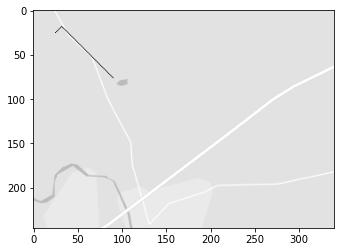

In [9]:
def DrawPath(image, path):
    for i in path:
        y=i[1]
        x=i[0]
        image[y][x]=0
    plt.imshow(image,cmap="gray")
DrawPath(test, Path)

In [10]:
def DistanceMatrix(matrix):
    shape=matrix.shape
    distance=np.zeros((shape))
    for i in range(shape[0]):
        for j in range(shape[1]):
            distance[i][j]=matrix[i][j].fromOrigin
    return distance

In [11]:
def weightedDistance2(image,currentPos, neighbourPos):
    currentPosY=currentPos.yCoordinate
    currentPosX=currentPos.xCoordinate
    Safety=neighbourPos.Danger
    SpeedMultiplier=neighbourPos.Speed
    nextPosY=neighbourPos.yCoordinate
    nextPosX=neighbourPos.xCoordinate
    return ((currentPosX-nextPosX)**2+(currentPosY-nextPosY)**2)**0.5*Safety*SpeedMultiplier


def DijkstraColoured(image, beginningX, beginningY, endX, endY, safeties=[1,1,1,1,1], speeds=[1,1,1,1,1]):
    UnVisitedNodes=[]
    distances=[]
    imageColours=[]
    imageRows, imageColumns,RGB=image.shape
    Positions=np.empty((imageRows,imageColumns),dtype=Position)
    for y in range(imageRows):
        for x in range(imageColumns):
            Positions[y][x]=Position(y,x)
            if imageColours.count(str(image[y][x][0])+str(image[y][x][1])+str(image[y][x][2]))==0:
                imageColours.append(str(image[y][x][0])+str(image[y][x][1])+str(image[y][x][2]))
            if y==beginningY and x==beginningX:
                Positions[beginningY][beginningX].fromOrigin=0
            Positions[y][x].Danger=safeties[imageColours.index(str(image[y][x][0])+str(image[y][x][1])+str(image[y][x][2]))]
            Positions[y][x].Speed=speeds[imageColours.index(str(image[y][x][0])+str(image[y][x][1])+str(image[y][x][2]))]
            UnVisitedNodes.append(Positions[y][x])
            distances.append(Positions[y][x].fromOrigin)
    while UnVisitedNodes[endY*imageColumns+endX].Visited==False:
        currentPos=np.argmin(distances)
        current=UnVisitedNodes[currentPos]
        yPos=current.yCoordinate
        xPos=current.xCoordinate
        current.Visited=True
        neighbours=Neighbouring(Positions, current)
        for neighbour in neighbours:
            distance=weightedDistance2(image,current,neighbour)
            if current.fromOrigin + distance < neighbour.fromOrigin:
                neighbour.fromOrigin=current.fromOrigin + distance
                neighbour.xRoad=current.xCoordinate
                neighbour.yRoad=current.yCoordinate
                UnVisitedNodes[neighbour.yCoordinate*imageColumns+neighbour.xCoordinate].fromOrigin=neighbour.fromOrigin
                UnVisitedNodes[neighbour.yCoordinate*imageColumns+neighbour.xCoordinate].xRoad=neighbour.xRoad
                UnVisitedNodes[neighbour.yCoordinate*imageColumns+neighbour.xCoordinate].yRoad=neighbour.yRoad
                distances[neighbour.yCoordinate*imageColumns+neighbour.xCoordinate]=neighbour.fromOrigin
        distances[currentPos]=np.inf
    return Positions


In [12]:
danger=[100,10,np.inf,5,5]
speed=[1,0.5,np.inf,0.25,0.25]

In [23]:
%%time
Matrix=DijkstraColoured(testcoloured,800,450, 600, 200, danger, speed)

Wall time: 35min 38s


In [18]:
def WholePath(matrix,endx,endy):
    Path=[]
    current=matrix[endy][endx]
    while current.xRoad != None:
        Path.append([current.xCoordinate,current.yCoordinate])
        current=matrix[current.yRoad][current.xRoad]
    return Path

In [24]:
path=WholePath(Matrix, 600, 200)
path

[[600, 200],
 [599, 201],
 [598, 202],
 [597, 203],
 [596, 204],
 [595, 205],
 [594, 206],
 [593, 207],
 [592, 208],
 [591, 209],
 [590, 210],
 [589, 211],
 [588, 212],
 [587, 213],
 [586, 214],
 [585, 215],
 [585, 216],
 [585, 217],
 [585, 218],
 [585, 219],
 [585, 220],
 [585, 221],
 [585, 222],
 [585, 223],
 [585, 224],
 [585, 225],
 [585, 226],
 [585, 227],
 [585, 228],
 [585, 229],
 [585, 230],
 [585, 231],
 [585, 232],
 [585, 233],
 [585, 234],
 [585, 235],
 [585, 236],
 [585, 237],
 [585, 238],
 [585, 239],
 [585, 240],
 [585, 241],
 [585, 242],
 [585, 243],
 [585, 244],
 [584, 245],
 [584, 246],
 [584, 247],
 [584, 248],
 [584, 249],
 [584, 250],
 [584, 251],
 [584, 252],
 [584, 253],
 [584, 254],
 [584, 255],
 [584, 256],
 [584, 257],
 [584, 258],
 [584, 259],
 [584, 260],
 [584, 261],
 [584, 262],
 [585, 263],
 [586, 264],
 [587, 265],
 [587, 266],
 [588, 267],
 [588, 268],
 [588, 269],
 [588, 270],
 [589, 271],
 [590, 272],
 [591, 273],
 [592, 274],
 [592, 275],
 [592, 276],

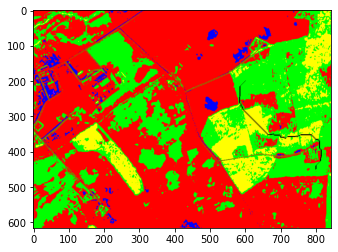

In [25]:
def ColourPath(image, path):
    copied=image.copy()
    for i in path:
        copied[i[1]][i[0]]=[0,0,0]
        copied[i[1]-1][i[0]+1]=[0,0,0]
        copied[i[1]+1][i[0]-1]=[0,0,0]
    return copied
pathed=ColourPath(testcoloured,path)
plt.imshow(pathed)